# Header

In [80]:
from main import *
import pandas as pd

In [81]:
df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/united_states/us_5950.csv')

In [82]:
df.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,20231103,United States,Wovens,RANCHO CUCAMONGA QUAKES,5950,BASEBALL,Headwear,Program,1
1,20231103,United States,Wovens,RENO ACES,5950,BASEBALL,Headwear,Program,1
2,20231025,United States,Other,SAN FRANCISCO GIANTS,5950,BASEBALL,Headwear,Custom,144
3,20231011,United States,Other,SAN DIEGO PADRES,5950,BASEBALL,Headwear,Custom,80
4,20231024,United States,Wovens,HOUSTON ASTROS,5950,BASEBALL,Headwear,Custom,864


In [83]:
df['SEASON_CONSOLIDATION'] = df['SEASON_CONSOLIDATION'].astype(str)
df_us_5950_custom = df[df['SEASON_CONSOLIDATION']=="Custom"]

In [86]:
df_us_5950_custom.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY,Year,Month
2,2023-10-25,United States,Other,SAN FRANCISCO GIANTS,5950,BASEBALL,Headwear,Custom,144,2023,10
3,2023-10-11,United States,Other,SAN DIEGO PADRES,5950,BASEBALL,Headwear,Custom,80,2023,10
4,2023-10-24,United States,Wovens,HOUSTON ASTROS,5950,BASEBALL,Headwear,Custom,864,2023,10
5,2013-02-01,United States,Wovens,NONE,5950,NONE,Headwear,Custom,198,2013,2
6,2014-04-09,United States,Other,TAMPA BAY RAYS,5950,BASEBALL,Headwear,Custom,36,2014,4


In [87]:
verify_timeseries(df_us_5950_custom)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format='%Y%m%d')
/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['PO_CREATED_DATE'].dt.year
/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main

[{'Year': 2025, 'Missing Months': [12]}]

In [84]:
df_us_5950_custom_pre_ts = prepare_pre_ts_data(df_us_5950_custom)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format='%Y%m%d')
/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['PO_CREATED_DATE'].dt.year
/mnt/batch/tasks/shared/LS_root/mounts/clusters/falconsvjam/code/Users/vlavanga/notebooks/main

In [85]:
df_us_5950_custom_pre_ts.head()

,Year,Month,ORDERED_QUANTITY
DATE,,,
2009-01-01,2009,1,157102
2009-02-01,2009,2,1606313
2009-03-01,2009,3,3476868
2009-04-01,2009,4,5093500
2009-05-01,2009,5,3882341


# Auto Arima

In [74]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [ ]:
def find_stable_start(ts, threshold=0.05):
    ts = ts.asfreq("MS").fillna(0)
    if ts.sum() == 0:
        return ts.index.min()

    cum = ts.cumsum() / ts.sum()
    stable = cum[cum > threshold]
    return stable.index[0] if len(stable) else ts.index.min()

In [58]:
df_us_5950_custom_pre_ts = df_us_5950_custom_pre_ts.reset_index()
df_us_5950_custom_pre_ts = df_us_5950_custom_pre_ts.set_index('DATE')
df_us_5950_custom_pre_ts.head()

,Year,Month,ORDERED_QUANTITY
DATE,,,
2009-01-01,2009,1,157102
2009-02-01,2009,2,1606313
2009-03-01,2009,3,3476868
2009-04-01,2009,4,5093500
2009-05-01,2009,5,3882341


In [78]:
df_temp = find_stable_start(df_us_5950_custom_pre_ts)

In [79]:
df_temp

Timestamp('2009-01-01 00:00:00', freq='MS')

In [60]:
train = df_us_5950_custom_pre_ts["2009":"2023"]
test = df_us_5950_custom_pre_ts["2024-01-01":"2024-12-01"]


In [65]:
train = df_us_5950_custom_pre_ts["2009":"2023"]
test = df_us_5950_custom_pre_ts["2024-01-01":"2024-12-01"]

y_train = train['ORDERED_QUANTITY']
y_test = test['ORDERED_QUANTITY']


In [66]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1)).ravel()


In [67]:
from pmdarima import auto_arima

model = auto_arima(
    y_train_scaled,
    m=12,
    seasonal=True,
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)


In [68]:
n_periods = len(y_test)
scaled_forecast = model.predict(n_periods=n_periods)


In [69]:
forecast = scaler.inverse_transform(scaled_forecast.reshape(-1,1)).ravel()


In [70]:
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Forecast": forecast
}, index=y_test.index)


In [71]:
mape = np.mean(np.abs((comparison_df["Actual"] - comparison_df["Forecast"]) /
                      comparison_df["Actual"])) * 100

print("Test MAPE:", round(mape, 2), "%")


Test MAPE: 35.21 %


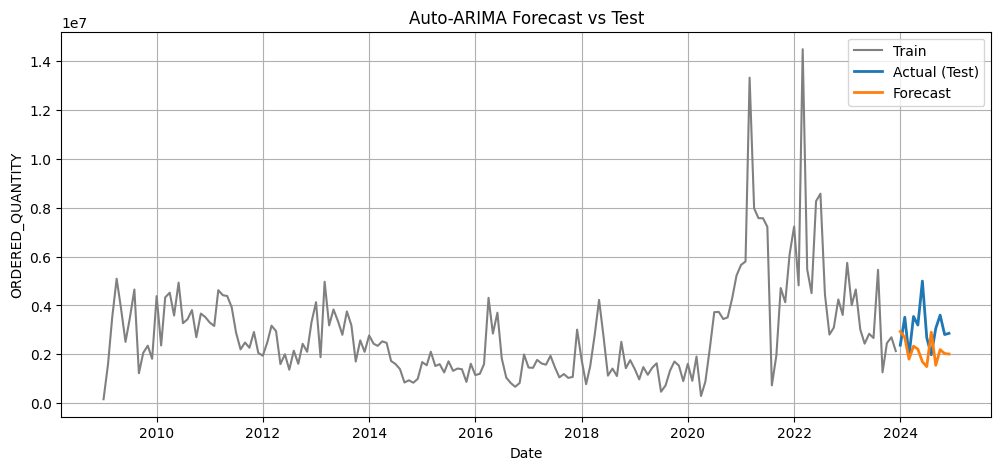

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Train", color='gray')
plt.plot(y_test.index, y_test, label="Actual (Test)", linewidth=2)
plt.plot(y_test.index, forecast, label="Forecast", linewidth=2)

plt.title("Auto-ARIMA Forecast vs Test")
plt.xlabel("Date")
plt.ylabel("ORDERED_QUANTITY")
plt.legend()
plt.grid(True)
plt.show()
